# Reproduce Modality Score Distribution Violin Plot

This notebook reproduces the violin plot showing score distributions by modality from the paper.

The plot shows how different input modalities (text vs. image encodings) affect transformer-based models' performance on ARC-AGI tasks.


## Setup and Imports


In [2]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Any
import numpy as np

# Configuration
MODALITY_TYPES = [
    "row_only",
    "col_only",
    "image_only",
    "row_col",
    "row_image",
    "col_image",
    "row_col_image",
]

# New JSON-based modalities (ascending order only)
JSON_MODALITY_TYPES = [
    "json_only",
    "row_col_json",
    "row_col_json_image",
    "image_json",
]

# Set up paths
NOTEBOOK_DIR = Path(".").resolve()
DATA_DIR = NOTEBOOK_DIR / "data" / "experiment_results"
PLOTS_DIR = NOTEBOOK_DIR / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Plots directory: {PLOTS_DIR}")


Notebook directory: /home/bwen/projects/arc-aif-agi/refs/AIF-ARC-AGI-public/generate-execute
Data directory: /home/bwen/projects/arc-aif-agi/refs/AIF-ARC-AGI-public/generate-execute/data/experiment_results
Plots directory: /home/bwen/projects/arc-aif-agi/refs/AIF-ARC-AGI-public/generate-execute/plots


## Load Experiment Results


In [ ]:
def load_results(results_file: Path) -> Dict[str, Any]:
    """Load results.json file."""
    with open(results_file, "r") as f:
        return json.load(f)

# Load the main cross-order experiment results (20251105_1142)
main_experiment_dir = DATA_DIR / "20251105_1142"
main_results_file = main_experiment_dir / "results.json"
if main_results_file.exists():
    summary = load_results(main_results_file)
    results = summary.get("results", [])
else:
    print(f"Warning: Main experiment results not found at {main_results_file}")
    summary = {}
    results = []

# Load new JSON-based experiment results from their respective folders
NEW_EXPERIMENT_DIRS = [
    (DATA_DIR / "20251108_1435", "json_only"),
    (DATA_DIR / "20251108_1444", "row_col_json"),
    (DATA_DIR / "20251108_1455", "row_col_json_image"),
    (DATA_DIR / "20251108_1504", "image_json"),
]

new_results = []
for exp_dir, expected_modality in NEW_EXPERIMENT_DIRS:
    results_file = exp_dir / "results.json"
    if results_file.exists():
        try:
            new_summary = load_results(results_file)
            # Ensure modality type is set
            if "modality_type" not in new_summary:
                new_summary["modality_type"] = expected_modality
            new_results.append(new_summary)
        except Exception as e:
            print(f"Warning: Could not load {results_file}: {e}")
    else:
        print(f"Warning: Results file not found: {results_file}")

print(f"Loaded {len(results)} original experiment results")
print(f"Loaded {len(new_results)} new JSON-based experiment results")
print(f"Session ID: {summary.get('session_id', 'N/A')}")
print(f"Model: {summary.get('model', 'N/A')}")
print(f"Temperature: {summary.get('temperature', 'N/A')}")
print(f"Number of training examples: {summary.get('num_train', 'N/A')}")
print(f"Number of test cases: {summary.get('num_test', 'N/A')}")

# Show available modalities
modalities_found = set(r.get("modality_type") for r in results if "error" not in r)
for new_summary in new_results:
    modality = new_summary.get("modality_type") or new_summary.get("result", {}).get("modality_type")
    if modality:
        modalities_found.add(modality)
print(f"\nAvailable modalities: {sorted(modalities_found)}")


Loaded 14 original experiment results
Loaded 4 new JSON-based experiment results
Session ID: 13e47133-modality_experiment-20251105_1142
Model: gemini/gemini-2.5-pro
Temperature: 0.3
Number of training examples: 3
Number of test cases: 2

Available modalities: ['col_image', 'col_only', 'image_json', 'image_only', 'json_only', 'row_col', 'row_col_image', 'row_col_json', 'row_col_json_image', 'row_image', 'row_only']


## Extract Cross-Order Scores


In [ ]:
def extract_cross_order_scores(results: List[Dict[str, Any]], new_summaries: List[Dict[str, Any]] = None) -> Dict[str, Dict[str, List[Dict[str, Any]]]]:
    """
    Extract cross-order scores from results.
    
    Returns:
        Dict with structure:
        {
            modality: {
                "held_out": [{asc_score, desc_score, hypothesis_order, held_out_idx}, ...],
                "test": [{asc_score, desc_score, hypothesis_order, test_idx}, ...],
                "held_out_reduced": [...],
                "test_reduced": [...]
            }
        }
    """
    cross_order_data = {}
    
    # Process original cross-order results
    for result in results:
        if "error" in result:
            continue
        
        modality = result["modality_type"]
        hypothesis_order = result["example_order"]
        
        if modality not in cross_order_data:
            cross_order_data[modality] = {
                "held_out": [],
                "test": [],
                "held_out_reduced": [],
                "test_reduced": [],
                "hypothesis_order": {}
            }
        
        cross_order_data[modality]["hypothesis_order"][hypothesis_order] = True
        
        # Extract held-out results (normal)
        for ho_result in result.get("held_out_results", []):
            if "error" not in ho_result:
                asc_score = ho_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = ho_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["held_out"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "held_out_idx": ho_result.get("held_out_idx")
                })
        
        # Extract test results (normal)
        for test_result in result.get("test_results", []):
            if "error" not in test_result:
                asc_score = test_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = test_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["test"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "test_idx": test_result.get("test_idx")
                })
        
        # Extract held-out results (reduced)
        for ho_result in result.get("held_out_results_reduced", []):
            if "error" not in ho_result:
                asc_score = ho_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = ho_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["held_out_reduced"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "held_out_idx": ho_result.get("held_out_idx")
                })
        
        # Extract test results (reduced)
        for test_result in result.get("test_results_reduced", []):
            if "error" not in test_result:
                asc_score = test_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = test_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["test_reduced"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "test_idx": test_result.get("test_idx")
                })
    
    # Process new ascending-only results
    if new_summaries:
        for new_summary in new_summaries:
            # Handle both formats: direct result dict or nested in "result" field
            result_data = new_summary.get("result", new_summary)
            if "error" in result_data:
                continue
            
            modality = result_data.get("modality_type") or new_summary.get("modality_type")
            if not modality:
                continue
            
            hypothesis_order = result_data.get("example_order", "ascending")
            
            if modality not in cross_order_data:
                cross_order_data[modality] = {
                    "held_out": [],
                    "test": [],
                    "held_out_reduced": [],
                    "test_reduced": [],
                    "hypothesis_order": {}
                }
            
            cross_order_data[modality]["hypothesis_order"][hypothesis_order] = True
            
            # For ascending-only experiments, set both asc_score and desc_score to the same value
            for ho_result in result_data.get("held_out_results", []):
                if "error" not in ho_result:
                    similarity = ho_result.get("similarity", 0.0)
                    cross_order_data[modality]["held_out"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,
                        "hypothesis_order": hypothesis_order,
                        "held_out_idx": ho_result.get("held_out_idx")
                    })
            
            for test_result in result_data.get("test_results", []):
                if "error" not in test_result:
                    similarity = test_result.get("similarity", 0.0)
                    cross_order_data[modality]["test"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,
                        "hypothesis_order": hypothesis_order,
                        "test_idx": test_result.get("test_idx")
                    })
            
            for ho_result in result_data.get("held_out_results_reduced", []):
                if "error" not in ho_result:
                    similarity = ho_result.get("similarity", 0.0)
                    cross_order_data[modality]["held_out_reduced"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,
                        "hypothesis_order": hypothesis_order,
                        "held_out_idx": ho_result.get("held_out_idx")
                    })
            
            for test_result in result_data.get("test_results_reduced", []):
                if "error" not in test_result:
                    similarity = test_result.get("similarity", 0.0)
                    cross_order_data[modality]["test_reduced"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,
                        "hypothesis_order": hypothesis_order,
                        "test_idx": test_result.get("test_idx")
                    })
    
    return cross_order_data

# Extract the data
cross_order_data = extract_cross_order_scores(results, new_results)

print(f"Extracted data for {len(cross_order_data)} modalities:")
for modality, data in cross_order_data.items():
    print(f"  {modality}:")
    print(f"    - Held-out (normal): {len(data['held_out'])} examples")
    print(f"    - Test (normal): {len(data['test'])} cases")
    print(f"    - Held-out (reduced): {len(data['held_out_reduced'])} examples")
    print(f"    - Test (reduced): {len(data['test_reduced'])} cases")


Extracted data for 11 modalities:
  row_only:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
  col_only:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
  image_only:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
  row_col:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
  row_image:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
  col_image:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
  row_col_image:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (r

Creating modality violin plot (sorted by median)...
✓ Saved violin plot: /home/bwen/projects/arc-aif-agi/refs/AIF-ARC-AGI-public/generate-execute/plots/modality_score_distribution_violin_sorted.png


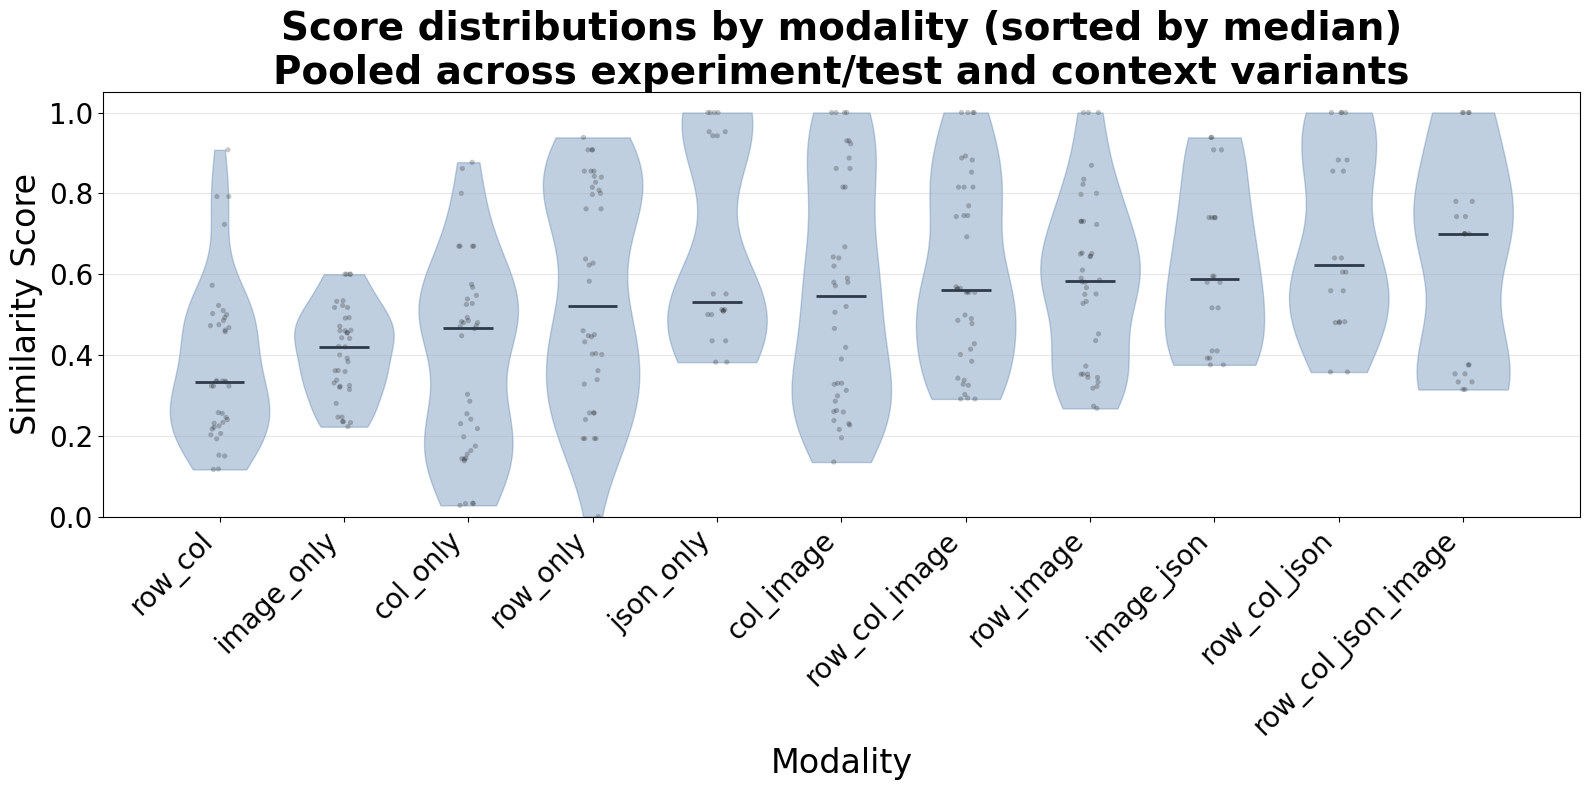

In [5]:
def create_modality_violin_plot(
    cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]],
    save: bool = True,
    order_by: str = "median"
):
    """
    Show distribution of original scores by modality, pooling across experiment/test and normal/reduced.
    - X-axis: modalities
    - Y-axis: similarity score
    - Visualization: violin per modality + jittered individual points
    - Optional ordering by median score
    """
    # Determine modalities available
    all_modality_types = MODALITY_TYPES + JSON_MODALITY_TYPES
    available_modalities = [m for m in all_modality_types if m in cross_order_data]
    if not available_modalities:
        print("No modalities found in cross_order_data")
        return None
    
    # Gather all scores per modality
    variant_keys = ["held_out", "test", "held_out_reduced", "test_reduced"]
    modality_to_scores: Dict[str, List[float]] = {m: [] for m in available_modalities}
    
    for modality in available_modalities:
        data = cross_order_data[modality]
        for key in variant_keys:
            for item in data.get(key, []) or []:
                asc = item.get("asc_score")
                desc = item.get("desc_score")
                if asc is not None:
                    modality_to_scores[modality].append(float(asc))
                if desc is not None:
                    modality_to_scores[modality].append(float(desc))
    
    # Remove modalities with no data
    modality_to_scores = {m: s for m, s in modality_to_scores.items() if len(s) > 0}
    if not modality_to_scores:
        print("No score data found to plot")
        return None
    
    # Optionally sort modalities by median score
    modalities = list(modality_to_scores.keys())
    if order_by == "median":
        modalities.sort(key=lambda m: np.median(modality_to_scores[m]))
    else:
        modalities = [m for m in available_modalities if m in modality_to_scores]
    
    # Prepare data in order
    data_in_order = [modality_to_scores[m] for m in modalities]
    positions = np.arange(len(modalities))
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 8))
    vp = ax.violinplot(
        data_in_order,
        positions=positions,
        widths=0.8,
        showmeans=False,
        showextrema=False,
        showmedians=True,
    )
    
    # Style violins
    violin_face = "#4C78A8"
    for body in vp["bodies"]:
        body.set_facecolor(violin_face)
        body.set_edgecolor(violin_face)
        body.set_alpha(0.35)
    if "cmedians" in vp:
        vp["cmedians"].set_color("#2F3A4A")
        vp["cmedians"].set_linewidth(2.0)
    
    # Overlay jittered individual points
    rng = np.random.default_rng(42)
    for i, scores in enumerate(data_in_order):
        if not scores:
            continue
        jitter = rng.uniform(-0.08, 0.08, size=len(scores))
        ax.scatter(
            np.full(len(scores), positions[i]) + jitter,
            scores,
            s=14,
            color="#000000",
            alpha=0.22,
            edgecolors="none",
        )
    
    # Axes formatting
    ax.set_xlabel("Modality", fontsize=24)
    ax.set_ylabel("Similarity Score", fontsize=24)
    title_order = " (sorted by median)" if order_by == "median" else ""
    
    ax.set_title(
        f"Score distributions by modality{title_order}\nPooled across experiment/test and context variants",
        fontsize=28,
        fontweight="bold",
    )
    
    # x tick labels
    xtick_labels = [m for m in modalities]
    ax.set_xticks(positions)
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_ylim([0, 1.05])
    ax.grid(True, axis="y", alpha=0.3)
    
    plt.tight_layout()
    
    if save:
        filename = "modality_score_distribution_violin_sorted.png" if order_by == "median" else "modality_score_distribution_violin.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches="tight")
        print(f"✓ Saved violin plot: {filepath}")
    
    return fig

# Create the violin plot (sorted by median)
print("Creating modality violin plot (sorted by median)...")
fig_violin_sorted = create_modality_violin_plot(cross_order_data, save=True, order_by="median")
plt.show()
